In [1]:
import os

import numpy as np
import pandas as pd
from tqdm.notebook import trange, tqdm
import itertools
from collections import defaultdict
from matplotlib import pyplot as plt
import time
import holidays
import networkx as nx
import scipy
from scipy.linalg import eig
from scipy.stats import kstest

from constants import (
    MAX_TAXI_ZONE_ID,
    location_ids,
    excluded_location_ids,
    location_id_to_index,
    num_locations,
    taxi_type,
)

np.set_printoptions(suppress=True)


## The goal of this notebook is to go through NYC FHVHV trip data to learn:

- time-varying rider arrival rates, $\lambda_{ij}(t)$
- time-varying trip travel times, $\mu_{ij}(t)$
- rider transition matrices, $P_{ij}$

### Initialization / Preprocessing (Create trip_data package)

In [2]:
Delta = 60 # Example: Time bin duration in minutes
T_max = int(24 * (60 / Delta)) # Number of time bins in a day
# YEARS = list(range(2019, 2025))
print(T_max)
YEARS = [2025]
us_holidays = holidays.US(years=YEARS)

filenames = os.listdir("training data")
filenames = [fn for fn in filenames if fn.startswith(taxi_type)]
# print(filenames)

24


In [4]:
# --- Data Processing (Combined Loop using Sort/Unique) ---

print("Processing data files...")
start_time = time.time()

# Initialize data structures
# 3D array for trip counts: (time_bin, pickup_location_idx, dropoff_location_idx)
trip_counts = np.zeros((T_max, num_locations, num_locations), dtype=np.int32)
# Dictionary to store lists of trip times: {(time_bin, pu_idx, do_idx): [time1, time2, ...]}
trip_times_dict = defaultdict(list)
# Set to store unique working dates encountered across all files
all_working_dates = set()

# Iterate through each data file
for file in tqdm(filenames):
    try:
        df = pd.read_parquet(f'training data/{file}') # Adjust path as needed
    except FileNotFoundError:
        print(f"Warning: File not found {file}, skipping.")
        continue

    # --- Common Filtering and Preprocessing ---

    # Ensure pickup_datetime is in datetime format
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    # Calculate trip time in seconds (or ensure it exists and is numeric)
    if 'trip_time' not in df.columns and 'tpep_pickup_datetime' in df.columns and 'tpep_dropoff_datetime' in df.columns:
         df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
         df['trip_time'] = (df['tpep_dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds()
    elif 'trip_time' in df.columns:
         df['trip_time'] = pd.to_numeric(df['trip_time'], errors='coerce')
    else:
        print(f"Warning: Cannot determine trip_time in {file}, skipping this file.")
        # continue # Option: skip entire file

    df.dropna(subset=['trip_time'], inplace=True)
    df = df[df['trip_time'] > 0]

    unique_dates_in_file = df.pickup_datetime.dt.date.unique()
    working_days_in_file = {date for date in unique_dates_in_file if date.weekday() < 5 and date not in us_holidays}
    all_working_dates.update(working_days_in_file)

    df = df[df.pickup_datetime.dt.date.isin(working_days_in_file)]
    df = df[df['PULocationID'].isin(location_ids) & df['DOLocationID'].isin(location_ids)]

    if df.empty: # Skip file if no valid data remains after filtering
        print(f"No valid data found in {file} after filtering, skipping.")
        continue

    df['time_bin'] = (df['pickup_datetime'].dt.hour * (60 / Delta) 
                      + df['pickup_datetime'].dt.minute / Delta).astype(int)
    df['pu_idx'] = df['PULocationID'].map(location_id_to_index)
    df['do_idx'] = df['DOLocationID'].map(location_id_to_index)

    df.dropna(subset=['pu_idx', 'do_idx', 'time_bin'], inplace=True) # Also drop if time_bin is bad
    df['pu_idx'] = df['pu_idx'].astype(int)
    df['do_idx'] = df['do_idx'].astype(int)
    df['time_bin'] = df['time_bin'].astype(int) # Ensure time_bin is also int

    # --- Accumulate Counts and Times using Sort/Unique ---

    # 1. Create combined keys as a structured array (efficient for sorting/unique)
    # Select only necessary columns
    relevant_cols = df[['time_bin', 'pu_idx', 'do_idx', 'trip_time']]
    keys = relevant_cols[['time_bin', 'pu_idx', 'do_idx']].to_records(index=False)

    # 2. Get indices that would sort the keys
    sorted_indices = np.argsort(keys, order=('time_bin', 'pu_idx', 'do_idx'))

    # 3. Apply sorting to keys and trip times
    sorted_keys = keys[sorted_indices]
    # Use .iloc for position-based indexing with the sorted indices array
    sorted_trip_times = relevant_cols['trip_time'].iloc[sorted_indices].to_numpy()

    # 4. Find unique keys, the index where each unique key first appears, and the count of each unique key
    unique_keys, start_indices, counts = np.unique(sorted_keys, 
                                                   return_index=True, return_counts=True)

    # 5. Update trip_counts array
    # Iterate through the unique keys found in *this file* and add their counts
    for key, count in zip(unique_keys, counts):
        # Ensure indices are within bounds (should be if mapping/filtering is correct)
        if (0 <= key.time_bin < T_max and 
           0 <= key.pu_idx < num_locations and 
           0 <= key.do_idx < num_locations):
             trip_counts[key.time_bin, key.pu_idx, key.do_idx] += count
        else:
             print(f"Warning: Out-of-bounds index encountered: {key}. Skipping count update.")

    # 6. Update trip_times_dict using slices from sorted_trip_times
    for key, start, count in zip(unique_keys, start_indices, counts):
         # Ensure indices are valid before accessing dict/array
         if (0 <= key.time_bin < T_max and 
            0 <= key.pu_idx < num_locations and 
            0 <= key.do_idx < num_locations):
             time_slice = sorted_trip_times[start : start + count]
             trip_times_dict[(key.time_bin, key.pu_idx, key.do_idx)].extend(time_slice)
         # No else needed here as the key wouldn't exist if indices were bad in step 5


# Calculate total number of unique working dates processed
num_dates = len(all_working_dates)
processing_time = time.time() - start_time
print(f"Processed data across {num_dates} unique working dates in {processing_time:.2f} seconds.")

# --- Prepare Data for Saving ---

# Flatten the trip times dictionary (same as before)
keys_list = []
counts_list = []
trip_time_chunks = []

print("Flattening trip time data...")
for key, times_list in tqdm(trip_times_dict.items()):
    if times_list:
        keys_list.append(key)
        counts_list.append(len(times_list))
        trip_time_chunks.append(np.array(times_list, dtype=np.float32))

if trip_time_chunks:
    all_trip_times_flat = np.concatenate(trip_time_chunks)
else:
    all_trip_times_flat = np.array([], dtype=np.float32)

key_counts_array = np.array([
    (*k, c) for k, c in zip(keys_list, counts_list)
], dtype=np.int32)


# --- Save Consolidated Data ---
output_filename = '2Months24_trip_data_.npz' 
print(f"Saving consolidated data to {output_filename}...")
np.savez_compressed(
    output_filename,
    trip_counts=trip_counts,
    num_dates=np.array(num_dates),
    all_trip_times=all_trip_times_flat,
    key_counts=key_counts_array
)
print("Data saved successfully.")


Processing data files...


  0%|          | 0/2 [00:00<?, ?it/s]

Processed data across 42 unique working dates in 163.61 seconds.
Flattening trip time data...


  0%|          | 0/811041 [00:00<?, ?it/s]

Saving consolidated data to 2Months24_trip_data_.npz...
Data saved successfully.


### Load trip_data

#### Task 1: analyze missing trips

In [5]:
print("\n--- Loading Consolidated Data ---")
data_filename = output_filename
try:
    with np.load(data_filename) as data:
        loaded_trip_counts = data['trip_counts']
        loaded_num_dates = data['num_dates'].item()
        loaded_all_trip_times_flat = data['all_trip_times']
        loaded_key_counts = data['key_counts']
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: Consolidated data file {data_filename} not found. Cannot proceed with tasks.")
    exit()


--- Loading Consolidated Data ---
Data loaded successfully.


#### Task 2: check irreducibility (positive-recurrence) for the Markov chain
- for $P_{ij}$:
- Check irreducibility
- Check positive recurrence by calculating stationary distribution

In [6]:
# --- Reconstruct the trip times dictionary (times in hours) ---
print("Reconstructing trip times dictionary (times in hours)...")
reconstructed_trip_times_dict_hrs = defaultdict(list)
start_index = 0
# Check if key_counts array is not empty before iterating
if loaded_key_counts.size > 0:
    for row in tqdm(loaded_key_counts):
        t, pu, do, count = row
        times_slice_seconds = loaded_all_trip_times_flat[start_index : start_index + count]
        reconstructed_trip_times_dict_hrs[(t, pu, do)] = times_slice_seconds / 3600.0
        start_index += count
else:
    print("Key counts array is empty, no trip times to reconstruct.")

print(f"Reconstructed dictionary contains {len(reconstructed_trip_times_dict_hrs)} entries (trips).")


# --- Task 1: Analyze Missing Trips ---
print("\n--- Task 1: Analyzing Missing Trips ---")
# (Code remains the same as previous version)
if loaded_trip_counts is not None and loaded_num_dates is not None:
    missing_trips = np.argwhere(loaded_trip_counts == 0)
    total_possible_slots = np.prod(loaded_trip_counts.shape)
    print("trip_counts shape:",loaded_trip_counts.shape)
    if total_possible_slots > 0:
         percentage_missing = len(missing_trips) / total_possible_slots * 100
         print(f"Percentage of missing trips (time block x region pair combination): {percentage_missing:.2f}%")
    else:
        print("Trip counts array is empty or invalid.")

    tripcount_overalltime = loaded_trip_counts.sum(axis=0)
    missing_trips_overalltime = np.argwhere(tripcount_overalltime == 0)
    total_possible_overall_slots = np.prod(tripcount_overalltime.shape)

    if total_possible_overall_slots > 0:
        percentage_missing_overall = len(missing_trips_overalltime) / total_possible_overall_slots * 100
        print(f"Percentage of missing trips (just region pair combination): {percentage_missing_overall:.2f}%")
    else:
        print("Overall trip counts array is empty or invalid.")
else:
    print("Trip counts data not loaded, skipping Task 1.")


Reconstructing trip times dictionary (times in hours)...


  0%|          | 0/811041 [00:00<?, ?it/s]

Reconstructed dictionary contains 811041 entries (trips).

--- Task 1: Analyzing Missing Trips ---
trip_counts shape: (24, 234, 234)
Percentage of missing trips (time block x region pair combination): 38.28%
Percentage of missing trips (just region pair combination): 5.82%


In [7]:
# --- Task 2: Check Irreducibility ---
print("\n--- Task 2: Checking Markov Chain Irreducibility per Time Bin ---")
# (Code remains the same as previous version)
if loaded_trip_counts is not None:
    task2_trip_counts = loaded_trip_counts.copy()
    task2_trip_counts[task2_trip_counts == 0] = 1

    irreducibility_results = []
    for t in range(T_max):
        P_t = task2_trip_counts[t]
        row_sums = P_t.sum(axis=1, keepdims=True)
        P_transition = np.zeros_like(P_t, dtype=float)
        valid_rows = row_sums > 0
        if np.any(valid_rows):
             P_transition[valid_rows[:,0]] = P_t[valid_rows[:,0]] / row_sums[valid_rows]

        G = nx.DiGraph(P_t > 0)
        is_irreducible = nx.is_strongly_connected(G)
        irreducibility_results.append(is_irreducible)

    print(f"All time bins are {'strongly connected (irreducible)' if all(irreducibility_results) else 'NOT all strongly connected (irreducible)'}")
else:
    print("Trip counts data not loaded, skipping Task 2.")


--- Task 2: Checking Markov Chain Irreducibility per Time Bin ---
All time bins are strongly connected (irreducible)


#### Task 3: Analyze trip times
- find the most frequent trip
- compare trip time distribution with an exponential dist
- plot trip time distribution


--- Task 3: Analyzing Specific Trip Time Distributions ---
Most frequent trip key (time_bin, pu_idx, do_idx): (np.int32(8), np.int32(68), np.int32(68)) with 8258 trips.
K-S Test (vs Exponential) for most frequent trip: D=0.2767, p-value=0
  (Suggests data does NOT follow an Exponential distribution at alpha=0.05)
Filtered 19 outliers from most frequent trip data (based on 0.1% and 99.9% percentiles).


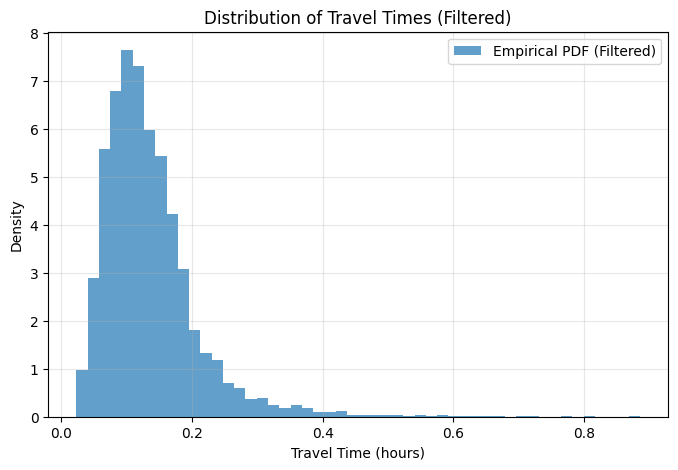

In [8]:
# --- Task 3: Analyze Specific Trip Times ---
print("\n--- Task 3: Analyzing Specific Trip Time Distributions ---")
# (Code remains the same as previous version)
if reconstructed_trip_times_dict_hrs:
    lengths = [(key, len(times)) for key, times in reconstructed_trip_times_dict_hrs.items()]
    if not lengths:
        print("No trip data available to analyze distributions.")
    else:
        lengths.sort(key=lambda x: x[1], reverse=True)
        most_frequent_key = lengths[0][0]
        num_trips_most_frequent = lengths[0][1]
        print(f"Most frequent trip key (time_bin, pu_idx, do_idx): {most_frequent_key} with {num_trips_most_frequent} trips.")

        travel_times_hrs = np.array(reconstructed_trip_times_dict_hrs[most_frequent_key])

        if travel_times_hrs.size > 1 and travel_times_hrs.mean() > 0:
            lambda_hat = 1.0 / travel_times_hrs.mean()
            try:
                D, p_value = kstest(
                    rvs=travel_times_hrs, cdf='expon', args=(0, 1.0/lambda_hat), alternative='two-sided'
                )
                print(f"K-S Test (vs Exponential) for most frequent trip: D={D:.4f}, p-value={p_value:.4g}")
                if p_value < 0.05: print(
                    "  (Suggests data does NOT follow an Exponential distribution at alpha=0.05)")
                else: print(
                    "  (Cannot reject the null hypothesis that data follows an Exponential distribution at alpha=0.05)")
            except Exception as e:
                 print(f"Could not perform KS-test: {e}")

            if travel_times_hrs.size > 100:
                lower_threshold = np.percentile(travel_times_hrs, 0.1)
                upper_threshold = np.percentile(travel_times_hrs, 99.9)
                travel_times_filtered = travel_times_hrs[(travel_times_hrs > lower_threshold) & (travel_times_hrs < upper_threshold)]
                print(f"Filtered {len(travel_times_hrs) - len(travel_times_filtered)} outliers from most frequent trip data (based on 0.1% and 99.9% percentiles).")

                plt.figure(figsize=(8, 5))
                plt.hist(travel_times_filtered, bins=50, density=True, alpha=0.7, label='Empirical PDF (Filtered)')
                plt.title(f'Distribution of Travel Times (Filtered)')
                plt.xlabel('Travel Time (hours)')
                plt.ylabel('Density')
                plt.legend()
                plt.grid(True, alpha=0.3)
                plt.show()
            else:
                print("Not enough data points in the most frequent trip to reliably filter/visualize.")
        else:
            print("Not enough data or zero mean for the most frequent trip to perform analysis.")
else:
    print("Reconstructed trip times dictionary is empty, skipping Task 3.")


--- Task 4: Calculating Mean Inverse Travel Times (Rate mu) ---
Calculating mu values...


  0%|          | 0/811041 [00:00<?, ?it/s]

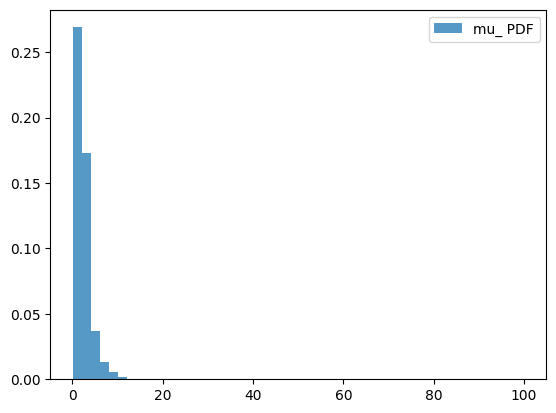

Calculated 811041 mu values.
Saved mu values to mu_calculated.npz

--- All Tasks Completed ---


In [9]:
# --- Task 4: Calculate Mean Inverse Travel Times (mu) ---

save_filename = '2Months24_mu.npz'
print("\n--- Task 4: Calculating Mean Inverse Travel Times (Rate mu) ---")
# (Code remains the same as previous version)
mu_ = np.full((T_max, num_locations, num_locations), np.nan, dtype=np.float64)

if reconstructed_trip_times_dict_hrs:
    print("Calculating mu values...")
    calculated_count = 0
    skipped_zero_mean = 0
    for key, arr_hrs in tqdm(reconstructed_trip_times_dict_hrs.items()):
        time_bin, pu_idx, do_idx = key
        arr = np.array(arr_hrs)

        if arr.size == 0: continue

        if arr.size > 2:
            lower_threshold = np.percentile(arr, 0.1)
            upper_threshold = np.percentile(arr, 99.9)
            arr_curtailed = arr[(arr > lower_threshold) & (arr < upper_threshold)]
            if arr_curtailed.size == 0: arr_curtailed = arr
        else:
            arr_curtailed = arr

        mean_time_hrs = np.mean(arr_curtailed)

        if mean_time_hrs > 0:
            mu_val = 1.0 / mean_time_hrs
            if mu_val > 100: mu_val = 100.0
            elif mu_val < 0.01: mu_val = 0.01
            mu_[time_bin, pu_idx, do_idx] = mu_val
            calculated_count += 1
        else:
            skipped_zero_mean +=1

    plt.hist(mu_.flatten(), bins=50, density=True, alpha=0.75, label='mu_ PDF')
    plt.legend()
    plt.show()
    
    print(f"Calculated {calculated_count} mu values.")
    if skipped_zero_mean > 0: print(f"Skipped {skipped_zero_mean} entries due to zero mean after filtering.")
    np.savez_compressed(save_filename, mu=mu_)
    print("Saved mu values to mu_calculated.npz")
else:
    print("Reconstructed trip times dictionary is empty, skipping Task 4.")

print("\n--- All Tasks Completed ---")

### Compute $\lambda_{ij}$

The number of arrivals $N_{it}^{(d)}$ on day $d$, for time bin $t$, at location $i$, is assumed to be distributed as:
$$N_{it}^{(d)} \sim \text{Poisson}(\lambda_{it}\cdot \Delta)$$

MLE for $\lambda_{it}$, per-hour rider arrival rate, is: $$\hat{\lambda}_{it} = \frac{1}{D\cdot (\Delta / 60)}\sum_{d=1}^D \sum_{j=1}^r N_{ijt}^{(d)}$$ where $D$ is the number of observed working days, and $\Delta$ is the time bin width in minutes, and $j$ is the destination location.
- Check if $\lambda_{it} > 0$ for all $i$ and $t$.

In [10]:
print("\n--- Calculate Departure Rates (Lambda) ---")

# Use the loaded trip counts and number of dates
trip_counts_data = loaded_trip_counts
num_dates_processed = loaded_num_dates

# Calculate total departures from each (time_bin, pu_idx) across all days
# Summing over axis=2 (do_idx) gives total trips *leaving* pu_idx at time_bin
total_departures = trip_counts_data.sum(axis=2) # Shape: (T_max, num_locations)
print('Total days observed:',num_dates_processed)
total_hours_observed = (Delta/60) * num_dates_processed # for one time bin
# Calculate lambda_ as the average departure rate per hour
# lambda_departure_rate[t, i] = avg number of trips *leaving* location i during time bin t, per hour.
if total_hours_observed > 0:
    lambda_departure_rate = total_departures / total_hours_observed # Shape: (T_max, num_locations)

    print("Shape of lambda_departure_rate array (T_max, num_locations):", lambda_departure_rate.shape)

    # Calculate the total system departure rate per hour for each time bin (sum across all pickup locations)
    total_system_rate_per_bin = lambda_departure_rate.sum(axis=1) # Shape: (T_max,)
    print("\nTotal system departure rate per hour for each time bin (sum across locations):")
    # Limit printing if it's too long
    if len(total_system_rate_per_bin) > 50:
         print(total_system_rate_per_bin[:25], "...", total_system_rate_per_bin[-25:])
    else:
        print(total_system_rate_per_bin)


    # Find indices (time_bin, pu_idx) where the average departure rate is zero
    zero_lambda_indices = np.argwhere(lambda_departure_rate == 0)
    print(f"\nThere are {len(zero_lambda_indices)}"+
          " (time_bin, pickup_location_idx) pairs with zero average departure rate.")

    # Optional: Print the actual indices if the number is small
    # if 0 < len(zero_lambda_indices) < 20:
    #    print("Indices (time_bin, pu_idx) with zero departure rate:")
    #    print(zero_lambda_indices)

else:
    print("Error: Total observation time is zero (num_dates might be zero?), cannot calculate rates.")


--- Calculate Departure Rates (Lambda) ---
Total days observed: 42
Shape of lambda_departure_rate array (T_max, num_locations): (24, 234)

Total system departure rate per hour for each time bin (sum across locations):
[16286.38095238  9758.61904762  6379.28571429  5480.11904762
  7356.0952381  10872.71428571 18888.30952381 30623.30952381
 37859.69047619 32102.35714286 27060.5        25425.19047619
 25838.73809524 27030.30952381 29689.71428571 30468.16666667
 31942.57142857 36875.71428571 38496.26190476 37148.83333333
 34359.61904762 32550.9047619  31606.4047619  27679.76190476]

There are 1 (time_bin, pickup_location_idx) pairs with zero average departure rate.
